In [254]:
import json
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from math import cos, sin, tan
from random import random
lamb = 0

In [255]:
with open("car_info.json", "r") as f:
    constants = json.load(f)

m = constants["car_mass"] \
    + constants["occupant_mass"] * constants["occupant_count"]
me = m + (constants["rotational_inertia_front"]+constants["rotational_inertia_back"])/constants["wheel_radius"]**2
Cdrag = constants["drag_coefficient"]
Croll = constants["rolling_resistance_coefficient"]
g = constants["gravity"]
rho = constants["air_density"]
frontal_area = constants["frontal_area"]
motor_efficiency = constants["motor_efficiency"]
auxiliary = constants["auxiliary_power"]
regen_efficiency = constants["regen_efficiency"]
solar = 570
full_battery = constants["total_battery_energy"]

In [256]:
height = []
with open("HighwayCircuitHeights.json", "r") as f:
    data = json.load(f)
    chunk_size = data[1]["distance"]-data[0]["distance"] # Chunk size is assumed constant throughout height data.
    num_chunks = len(data)
    target = full_battery*(data[-1]["distance"]/1000000)
    for chunk in data:
        height.append(chunk["height"])

c=chunk_size
n=num_chunks

grad = [math.atan((height[(i+1) % n]-height[(i-1) % n])/(2*c)) for i in range(len(height))]


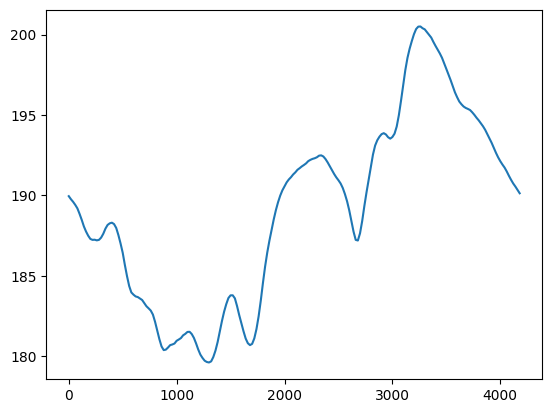

In [257]:
plt.plot([20*i for i in range(num_chunks)], height)

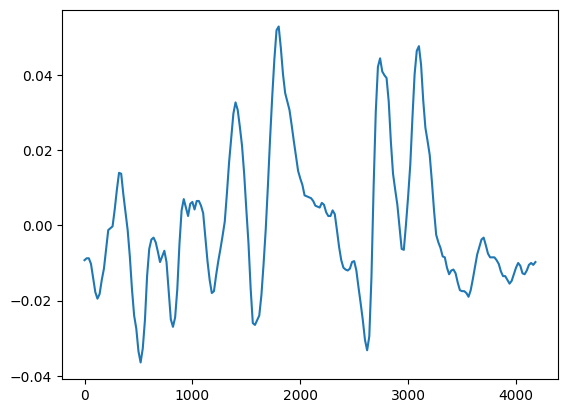

In [258]:
plt.plot([20*i for i in range(num_chunks)], grad)

Hyperparameters:

In [259]:
lr_max = 0.9
init_v = 30
epsilon = 136800000*0.005

In [260]:
def Phi(v,theta): # Phi_i
    Aero = Cdrag * rho * frontal_area * v**2 / 2
    Roll = Croll * m * g * cos(theta)
    Grad = m * g * sin(theta) 
    return Aero + Roll + Grad

In [261]:
def Hi_star(v):
    Hs = [0]*n

    for i in range(n):
        Hs[i] = c*(auxiliary-solar)/(v[i]*cos(grad[i])) + c/(cos(grad[i])*motor_efficiency)*Phi(v[i],grad[i])

    return Hs

In [262]:
def Hi_star_error(Hs, v):
    return (1-lamb)*(sum(Hs)-target)**2+lamb*sum([c/(v[i]*cos(grad[i])) for i in range(num_chunks)])

In [263]:
def Hi_star_error_gradients(Hs, v):
    error_grad = [0]*n

    for i in range(n):
        error_grad[i] = 2*(1-lamb)*(-c*(auxiliary-solar)/(v[i]**2 *cos(grad[i])) + c/(cos(grad[i])*motor_efficiency)*Cdrag*rho*frontal_area*v[i])*(sum(Hs)-target)-lamb*c/(v[i]**2 *cos(grad[i]))

    return error_grad


Core Gradient Descent Loop

 25%|██▌       | 1274/5000 [00:01<00:03, 1032.42it/s]


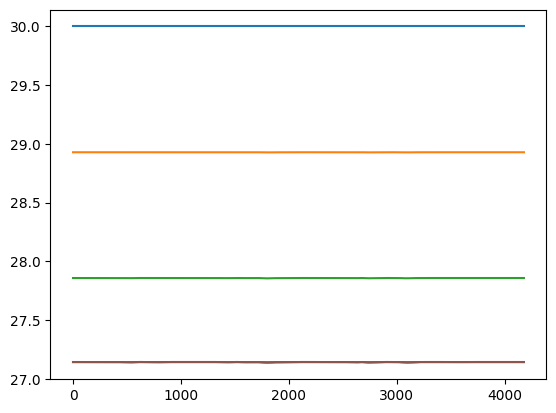

In [264]:
%matplotlib inline

v = [init_v]*n
#v = [vee+random()/10 for vee in v]

loss_history = []
v_history = []

cc = 5000
best_v = v

lamb = 0

lr = lr_max
init_error = Hi_star_error(Hi_star(v), v)
best_error = init_error

for count in tqdm(range(cc)):

    if count % (cc//20) == 0: 
        plt.plot([20*i for i in range(num_chunks)], v)
        plt.show
        v_history.append(v)

    Hs = Hi_star(v)
    error = Hi_star_error(Hs, v)

    if error <= best_error:
        best_error = error
        best_v = v
        loss_history.append(error)
    else:
        v = best_v
        lr = lr_max*math.sqrt(error/init_error)

    if error < 1e-05:
        break

    #if (error-best_error) > best_error*2:
    #    break

    #
    #if (error) > best_error:
    #    break
    #

    ### DELETEME
    if count >= cc:
        break
    ###

    error_grads = Hi_star_error_gradients(Hs, v)
    erg_sum = sum([abs(error_grad) for error_grad in error_grads])
    v = [abs(v[i]-lr*error_grads[i]/erg_sum) for i in range(num_chunks)]
    


Best error: 3.916339834707881e-06 
Average velocity: 97.70929828994203


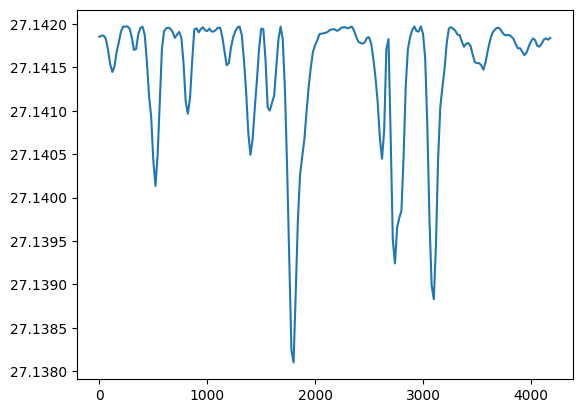

In [265]:
print("Best error:",best_error, "\nAverage velocity:", sum(best_v)/len(best_v)*3.6)
plt.plot([20*i for i in range(num_chunks)], best_v)
plt.show()

Log loss history


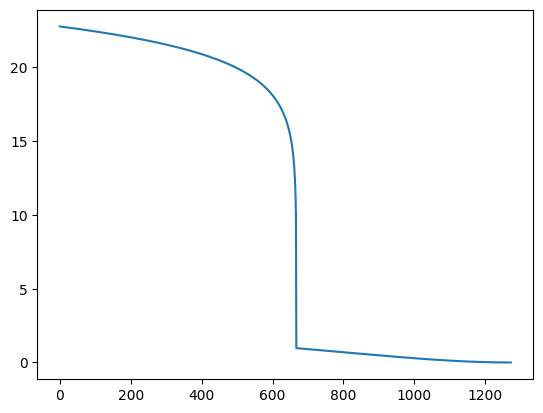

Final loop error: 3.916339834707881e-06


In [266]:
print("Log loss history")
plt.plot([math.log(loss+1) for loss in loss_history])
plt.show()

print("Final loop error:", loss_history[-1])

In [267]:
v = best_v
Hs = Hi_star(v)
total_lap_energy= sum(Hs)
print(full_battery, total_lap_energy*1000000/(n*c))

136800000.0 136148570.95738703
